In [ ]:
import numpy as np
import os
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from target import Target
from retrieval import Retrieval
from parameters import Parameters
import figures as figs

def init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='freechem',
                   Nlive=400,tol=0.5,cloud_mode='gray',GP=True):

    brown_dwarf = Target(brown_dwarf)
    output=f'{chem}_{PT_type}_N{Nlive}_ev{tol}' # output folder name

    constant_params={} # add if needed
    free_params = {'rv': ([2,20],r'$v_{\rm rad}$'),
                'vsini': ([0,40],r'$v$ sin$i$'),
                'log_g':([3,5],r'log $g$'),
                'epsilon_limb': [(0.2,1), r'$\epsilon_\mathrm{limb}$']} # limb-darkening coefficient (0-1)

    if PT_type=='PTknot':
        pt_params={'T0' : ([1000,4000], r'$T_0$'), # bottom of the atmosphere (hotter)
                'T1' : ([0,4000], r'$T_1$'),
                'T2' : ([0,4000], r'$T_2$'),
                'T3' : ([0,4000], r'$T_3$'),
                'T4' : ([0,4000], r'$T_4$'),} # top of atmosphere (cooler)
        free_params.update(pt_params)

    if PT_type=='PTgrad':
        pt_params={'dlnT_dlnP_0': ([0.,0.4], r'$\nabla T_0$'), # gradient at T0 
                'dlnT_dlnP_1': ([0.,0.4], r'$\nabla T_1$'), 
                'dlnT_dlnP_2': ([0.,0.4], r'$\nabla T_2$'), 
                'dlnT_dlnP_3': ([0.,0.4], r'$\nabla T_3$'), 
                'dlnT_dlnP_4': ([0.,0.4], r'$\nabla T_4$'), 
                'T0': ([1000,4000], r'$T_0$')} # at bottom of atmosphere
        free_params.update(pt_params)

    # if equilibrium chemistry, define [Fe/H], C/O, and isotopologue ratios
    if chem=='equchem':
        chemistry={'C/O':([0,1], r'C/O'), 
                'Fe/H': ([-1.5,1.5], r'[Fe/H]'), 
                'log_C12_13_ratio': ([1,12], r'log $\mathrm{^{12}C/^{13}C}$'), 
                'log_O16_18_ratio': ([1,12], r'log $\mathrm{^{16}O/^{18}O}$'), 
                'log_O16_17_ratio': ([1,12], r'log $\mathrm{^{16}O/^{17}O}$'),
                'log_HF':([-12,-1],r'log HF')}
            
    if chem=='quequchem': # quenched equilibrium chemistry
        chemistry={'C/O':([0,1], r'C/O'), 
                'Fe/H': ([-1.5,1.5], r'[Fe/H]'), 
                'log_C12_13_ratio': ([1,12], r'log $\mathrm{^{12}C/^{13}C}$'), 
                'log_O16_18_ratio': ([1,12], r'log $\mathrm{^{16}O/^{18}O}$'), 
                'log_O16_17_ratio': ([1,12], r'log $\mathrm{^{16}O/^{17}O}$'),
                'log_Pqu_CO_CH4': ([-6,2], r'log P$_{qu}$(CO,CH$_4$,H$_2$O)'),
                'log_Pqu_NH3': ([-6,2], r'log P$_{qu}$(NH$_3$)'),
                'log_Pqu_HCN': ([-6,2], r'log P$_{qu}$(HCN)'),
                'log_HF':([-12,-1],r'log HF')}  
        
    # if free chemistry, define VMRs
    if chem=='freechem': 
        chemistry={'log_H2O':([-12,-1],r'log H$_2$O'),
                'log_12CO':([-12,-1],r'log $^{12}$CO'),
                'log_13CO':([-12,-1],r'log $^{13}$CO'),
                'log_C18O':([-12,-1],r'log C$^{18}$O'),
                'log_C17O':([-12,-1],r'log C$^{17}$O'),
                'log_CH4':([-12,-1],r'log CH$_4$'),
                'log_NH3':([-12,-1],r'log NH$_3$'),
                'log_HCN':([-12,-1],r'log HCN'),
                'log_HF':([-12,-1],r'log HF'),
                'log_H2(18)O':([-12,-1],r'log H$_2^{18}$O'),
                'log_H2S':([-12,-1],r'log H$_2$S')}
        
    if cloud_mode=='gray':
        cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                    'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                    'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
        free_params.update(cloud_props)

    if cloud_mode=='MgSiO3':
        cloud_props={'fsed': ([0,20], r'$f_\mathrm{sed}$'), # sedimentation parameter for particles
                    'sigma_lnorm': ([0.8,1.5], r'$\sigma_{l,norm}$'), # width of the log-normal particle distribution
                    'log_Kzz':([5,15],r'log $K_{zz}$')} # eddy diffusion parameter (atmospheric mixing)
        free_params.update(cloud_props)
        
    if GP==True: # add uncertainty scaling
        GP_params={'log_a': ([-1,1], r'$\log\ a$'), # one is enough, will be multipled with order/det error
                'log_l': ([-3,0], r'$\log\ l$')}
        free_params.update(GP_params)

    free_params.update(chemistry)
    parameters = Parameters(free_params, constant_params)
    cube = np.random.rand(parameters.n_params)
    parameters(cube)

    retrieval=Retrieval(target=brown_dwarf,parameters=parameters,
                    output_name=output,chemistry=chem,PT_type=PT_type)
    return retrieval

#retrieval=init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='freechem',Nlive=400,tol=0.5)
#retrieval.evaluate(makefigs=False)

#retrieval2=init_retrieval(brown_dwarf='2M1425',PT_type='PTgrad',chem='freechem',Nlive=400,tol=0.5)
#retrieval2.evaluate(makefigs=False)


In [2]:
retrieval2=init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='equchem',Nlive=400,tol=0.5)
retrieval2.evaluate(makefigs=False)


In [3]:
retrieval=init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='freechem',Nlive=400,tol=0.5)
retrieval.evaluate(makefigs=False)

In [4]:
retrieval3=init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='quequchem',Nlive=400,tol=0.5)
retrieval3.evaluate(makefigs=False)

In [7]:
import figures as figs
figs.VMR_plot_new(retrieval_object=retrieval,retrieval_object2=retrieval2,retrieval_object3=retrieval3,molecules=['H2O','H2(18)O','12CO','13CO','CH4','H2S'])


In [ ]:
import figures as figs

figs.VMR_plot_new(retrieval)

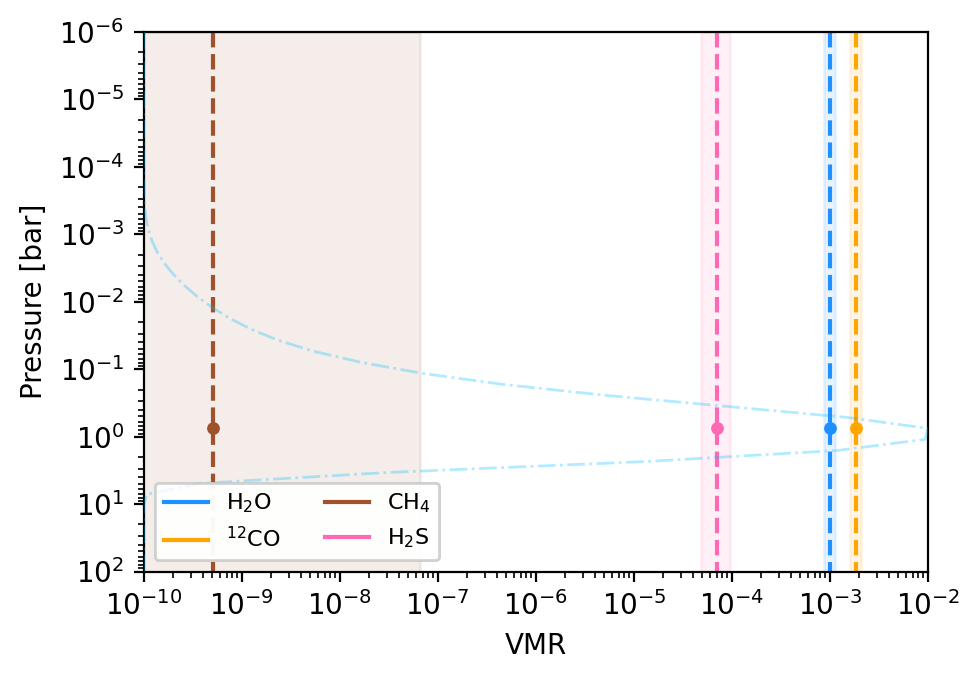

In [10]:
from figures import *
# new VMR plot with errors on freechem and equchem
import matplotlib.ticker
from matplotlib.ticker import MultipleLocator
from matplotlib import pyplot as plt, ticker as mticker

def VMR_plot_new(retrieval_object,molecules=['H2O','12CO','CH4','H2S'],fs=10,comp_equ=False,**kwargs):

    #prefix=retrieval_object.callback_label if retrieval_object.callback_label=='final_' else ''
    prefix=''
    suffix=''
    output_dir=retrieval_object.output_dir
    fig,ax=plt.subplots(1,1,figsize=(5,3.5),dpi=200)
    species_info = pd.read_csv(os.path.join('species_info.csv'))
    alpha=0.6 if 'retrieval_object2' in kwargs or comp_equ==True else 1
    legend_labels=0
    xmin,xmax=1e-10,1e-2
    chemleg=[] # legend for chemistry
    pressure=retrieval_object.model_object.pressure

    def plot_VMRs(retr_obj,ax,ax2):
        
        if retr_obj.chemistry=='freechem' and 'retrieval_object2' not in kwargs:
            linestyle='dashed'
            chemleg.append(Line2D([0], [0], color='k',linestyle=linestyle,linewidth=2,alpha=0.7,label='Free'))
        elif retr_obj.chemistry=='freechem' and 'retrieval_object2' in kwargs:    
            chemleg.append(Line2D([0], [0], marker='o',color='k',markerfacecolor='k',linewidth=2,alpha=0.7,label='Free'))
        elif retr_obj.chemistry=='equchem':
            linestyle='solid'
            chemleg.append(Line2D([0], [0], color='k',linestyle=linestyle,linewidth=2,alpha=0.3,label='Equ'))
        elif retr_obj.chemistry=='quequchem':
            linestyle='dotted'
            chemleg.append(Line2D([0], [0], color='k',linestyle=linestyle,linewidth=2,alpha=0.3,label='Quench'))

        if retr_obj.chemistry=='freechem':
            # somethings wrong with this...
            contribution_plot=retr_obj.summed_contr/np.max(retr_obj.summed_contr)*(xmax-xmin)+xmin
            ax2.plot(contribution_plot,retr_obj.model_object.pressure[::-1],
                    lw=1,alpha=0.3,color=retr_obj.color1,linestyle='dashdot')
            ax2.set_xlim(np.min(contribution_plot),np.max(contribution_plot))
            ax2.set_ylim(np.min(pressure),np.max(pressure))
            contr_max=pressure[np.where(retr_obj.summed_contr==np.max(retr_obj.summed_contr))[0]]
            ax2.set_yscale('log')
            #ax2.fill_between([xmin,xmax],sm1,sp1,color=retr_obj.color1,alpha=0.05)

        for species in molecules:
            color=species_info.loc[species_info["name"]==species]['color'].values[0]
            label=species_info.loc[species_info["name"]==species]['mathtext_name'].values[0]
            if retr_obj.chemistry=='freechem':
                label=label if legend_labels==0 else '_nolegend_' 
                VMR=10**retr_obj.params_dict[f'log_{species}']
                idx=list(retr_obj.parameters.params).index(f'log_{species}')
                sm3,sm2,sm1,median,sp1,sp2,sp3 = 10**np.array(np.percentile(retr_obj.posterior[:,idx],[0.2,2.3,15.9,50.0,84.1,97.7,99.8], axis=-1))
                if 'retrieval_object2' not in kwargs:
                    ax.plot(np.ones_like(pressure)*VMR,pressure,label=label,linestyle=linestyle,c=color)
                    ax.fill_betweenx(pressure,sm2,sp2,color=color,alpha=0.1) # 95% confidence interval
                    ax.scatter(VMR,contr_max, color=color,s=13)
                else: # plot only as point to avoid cluttering
                    ax.scatter(VMR,contr_max, color=color,s=13)
                    ax.plot([sm2,sp2],[contr_max,contr_max], color=color,lw=1.5)
            elif retr_obj.chemistry in ['equchem','quequchem']:
                label=label if legend_labels==0 else '_nolegend_'
                if comp_equ==False:
                    sm3,sm2,sm1,median,sp1,sp2,sp3=np.percentile(retr_obj.VMR_dict[species], [0.2,2.3,15.9,50.0,84.1,97.7,99.8], axis=0)
                    ax.plot(median,pressure,label=label,alpha=alpha,linestyle=linestyle,c=color)
                    #ax.fill_betweenx(pressure,sm1,sp1,color=color,alpha=0.1)
                    if retr_obj.chemistry=='equchem':
                        ax.fill_betweenx(pressure,sm2,sp2,color=color,alpha=0.1) # 95% confidence interval
                    #ax.fill_betweenx(pressure,sm3,sp3,color=color,alpha=0.1)
                    elif retr_obj.chemistry=='quequchem':
                        ax.fill_betweenx(pressure,sm2,sp2,color=color,alpha=0.05,hatch='x') # 95% confidence interval
                else:
                    ax.plot(retr_obj.model_object.VMRs[species],pressure,label=label,alpha=alpha,linestyle=linestyle,c=color)

    
    ax2 = ax.inset_axes([0,0,1,1]) # [x0, y0, width, height] , for emission contribution

    plot_VMRs(retrieval_object,ax=ax,ax2=ax2)
    legend_labels=1 if 'retrieval_object2' not in kwargs else 0 # only make legend labels once 

    # compare freechem VMRs to equilibrium chemistry with other retrieved params remainig equal
    if comp_equ==True:
        if getpass.getuser() == "grasser": # when runnig from LEM
            from atm_retrieval.retrieval import Retrieval
            from atm_retrieval.parameters import Parameters
        elif getpass.getuser() == "natalie": # when testing from my laptop
            from retrieval import Retrieval
            from parameters import Parameters

        parameters_equ = retrieval_object.params_dict
        parameters_equ.update({'C/O': retrieval_object.params_dict['C/O'],
                        'Fe/H': retrieval_object.params_dict['C/H'],
                        'log_C12_13_ratio': retrieval_object.params_dict['log_12CO/13CO'],
                        'log_O16_18_ratio': retrieval_object.params_dict['log_H2O/H2(18)O'],
                        'log_O16_17_ratio': retrieval_object.params_dict['log_12CO/C17O']})
        parameters_equ = Parameters({}, parameters_equ)
        parameters_equ.param_priors['log_l']=[-3,0]
        retrieval_equ = Retrieval(target=retrieval_object.target,parameters=parameters_equ, 
                                  output_name=retrieval_object.output_name,
                                chemistry='equchem',PT_type=retrieval_object.PT_type)
        retrieval_equ.model_object=pRT_spectrum(retrieval_equ)
        plot_VMRs(retrieval_equ,ax=ax,ax2=ax2)

    if 'retrieval_object2' in kwargs: # compare two retrievals
        prefix=''
        suffix='_2'
        retrieval_object2=kwargs.get('retrieval_object2')
        plt.gca().set_prop_cycle(None) # reset color cycle
        plot_VMRs(retrieval_object2,ax=ax,ax2=ax2)
        legend_labels=1
        comparison_dir=pathlib.Path(f'{retrieval_object.output_dir}/comparison') # store output in separate folder
        comparison_dir.mkdir(parents=True, exist_ok=True)
        output_dir=comparison_dir

    if 'retrieval_object3' in kwargs: # compare three retrievals
        suffix='_3'
        retrieval_object3=kwargs.get('retrieval_object3')
        plt.gca().set_prop_cycle(None) # reset color cycle
        plot_VMRs(retrieval_object3,ax=ax,ax2=ax2)

    leg=ax.legend(fontsize=fs*0.8,ncol=int(len(molecules)/2),loc='lower left')
    for lh in leg.legend_handles:
        lh.set_alpha(1)
    for line in leg.get_lines():
        line.set_linestyle('-')
    ax.add_artist(leg)
    if comp_equ==True or 'retrieval_object2' in kwargs:
        leg2=ax.legend(handles=chemleg,fontsize=fs*0.8,loc='upper left')
        ax.add_artist(leg2)
    
    ax2.axis('off')
    ax2.set_facecolor('none')
    ax.set(xlabel='VMR', ylabel='Pressure [bar]',yscale='log',xscale='log',
        ylim=(np.max(pressure),np.min(pressure)),xlim=(xmin,xmax))   
    ax.tick_params(labelsize=fs)
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.xaxis.set_major_locator(MultipleLocator(1e-2))
    ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    ax.set_xlabel('VMR', fontsize=fs)
    ax.set_ylabel('Pressure [bar]', fontsize=fs)
    fig.tight_layout()
    #fig.savefig(f'{output_dir}/{prefix}VMR_plot{suffix}.pdf')
    #plt.close()

#VMR_plot_new(retrieval_object=retrieval,retrieval_object2=retrieval2,retrieval_object3=retrieval3)
VMR_plot_new(retrieval_object=retrieval)

In [2]:
retrieval=init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='freechem',Nlive=400,tol=0.5)
retrieval.evaluate(makefigs=False,del_atm=False)

retrieval2=init_retrieval(brown_dwarf='2M1425',PT_type='PTgrad',chem='freechem',Nlive=400,tol=0.5)
retrieval2.evaluate(makefigs=False,del_atm=False)

/home/natalie/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [16]:
# calc correlation coefficient
import numpy as np

def corr(BD):
    metall=np.load(f'/home/natalie/Desktop/atm_retrieval/{BD}/freechem_PTgrad_N400_ev0.5/ratios_posterior.npy')[:,1:2].flatten()
    post=np.load(f'/home/natalie/Desktop/atm_retrieval/{BD}/freechem_PTgrad_N400_ev0.5/final_posterior.npy')
    logg=post[:,2]
    r=np.corrcoef(logg,metall)
    print('\nCorr betw logg & [C/H]:',r[0,1])
    H2O=post[:,12]
    CO=post[:,11]
    r=np.corrcoef(H2O,CO)
    print(np.median(H2O),np.median(CO))
    print('Corr betw H2O & CO:',r[0,1])

corr('2M0355')
corr('2M1425')


Corr betw logg & [C/H]: 0.7018300805415659
11.345865727587707 -2.28972803099281
Corr betw H2O & CO: -0.07303033517316188

Corr betw logg & [C/H]: 0.47231534023230537
8.301373609012293 -1.4534112167424897
Corr betw H2O & CO: 0.12898667726061266


In [3]:
import figures as figs
figs.compare_retrievals(retrieval,retrieval2)

In [ ]:
import matplotlib.pyplot as plt
import pathlib
import corner

def compare_metall_logg(retrieval_object1,retrieval_object2,fs=12,only_params=['log_g'],**kwargs):
    
    labels=list(retrieval_object1.parameters.param_mathtext.values())
    indices=[]
    for key in only_params:
        idx=list(retrieval_object1.parameters.params).index(key)
        indices.append(idx)
    posterior1=np.array([retrieval_object1.posterior[:,i] for i in indices]).T
    posterior2=np.array([retrieval_object2.posterior[:,i] for i in indices]).T
    labels=np.array([labels[i] for i in indices])

    total_posterior1=np.hstack([posterior1,retrieval_object1.ratios_posterior[:,1:2]]) # only C/H
    total_posterior2=np.hstack([posterior2,retrieval_object2.ratios_posterior[:,1:2]]) # only C/H
    labels=np.append(labels,'[C/H]')

    figsize=4
    fig = plt.figure(figsize=(figsize,figsize)) # fix size to avoid memory issues

    def plot_corner(posterior,retr_obj,labels,fig,getfig=False):
        fig = corner.corner(posterior, 
                        labels=labels, 
                        title_kwargs={'fontsize': fs},
                        label_kwargs={'fontsize': fs*0.8},
                        color=retr_obj.color1,
                        linewidths=0.5,
                        fill_contours=True,
                        quantiles=[0.16,0.5,0.84],
                        title_quantiles=[0.16,0.5,0.84],
                        show_titles=True,
                        plot_contours=True,
                        hist_kwargs={'density': False,
                                    'fill': True,
                                    'alpha': 0.5,
                                    'edgecolor': 'k',
                                    'linewidth': 1.0},
                        fig=fig,
                        quiet=True)
        
        titles = [axi.title.get_text() for axi in fig.axes]
        if getfig:
            return fig,titles
        else:
            return titles
        
    fig,titles1=plot_corner(total_posterior1,retrieval_object1,labels,fig,getfig=True)
    titles2=plot_corner(total_posterior2,retrieval_object2,labels,fig)
    enum=[0,1]
    titles_list=[titles1,titles2]
    colors_list=[retrieval_object1.color1,retrieval_object2.color1]

    for i, axi in enumerate(fig.axes):
        fig.axes[i].title.set_visible(False) # remove original titles
        fig.axes[i].xaxis.label.set_fontsize(fs)
        fig.axes[i].yaxis.label.set_fontsize(fs)
        fig.axes[i].tick_params(axis='both', which='major', labelsize=fs*0.8)
        fig.axes[i].tick_params(axis='both', which='minor', labelsize=fs*0.8)
        
    for run,titles_list,color in zip(enum,titles_list,colors_list):
        # add new titles
        for j, title in enumerate(titles_list):
            if title == '':
                continue
            
            # first only the name of the parameter
            s = title.split('=')
            if len(enum)==2:
                y_title=1.45
                y=y_title-(0.2*(run+1))
            elif len(enum)==3:
                y_title=1.47
                y=y_title-0.12-(0.13*(run+0.2))
            if run == 0: # first retrieval, add parameter name
                fig.axes[j].text(0.5, y_title, s[0], fontsize=fs,
                                ha='center', va='bottom',
                                transform=fig.axes[j].transAxes,
                                color='k',
                                weight='normal')
            # add parameter value with custom color and spacing
            fig.axes[j].text(0.5, y, s[1], fontsize=fs,
                            ha='center', va='bottom',
                            transform=fig.axes[j].transAxes,
                            color=color,
                            weight='normal')

    plt.subplots_adjust(wspace=0, hspace=0)
    comparison_dir=pathlib.Path(f'{retrieval_object1.output_dir}/comparison') # store output in separate folder
    comparison_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(f'{comparison_dir}/cornerplot_ratios_logg.pdf',bbox_inches="tight",dpi=200)
    plt.close()

compare_metall_logg(retrieval,retrieval2)

In [15]:
p=np.load('/home/natalie/Desktop/atm_retrieval/2M1425/freechem_PTgrad_N400_ev0.5/final_posterior.npy')
p.shape

(4423, 26)

In [12]:
print(retrieval.ratios_posterior[:,:2].shape)
plot_posterior.shape

(3724, 2)


(3724, 2)

In [7]:
np.append(labels,['C/O','[C/H]',r'log $^{12}$CO/$^{13}$CO',r'log $^{12}$CO/C$^{17}$O',
                r'log $^{12}$CO/C$^{18}$O',r'log H$_2^{16}$O/H$_2^{18}$O'])

array(['log $g$', '$v$ sin$i$', 'C/O', '[C/H]', 'log $^{12}$CO/$^{13}$CO',
       'log $^{12}$CO/C$^{17}$O', 'log $^{12}$CO/C$^{18}$O',
       'log H$_2^{16}$O/H$_2^{18}$O'], dtype='<U27')

In [7]:
# determine sigma difference between freechem/equchem/quechem

import pathlib
import pickle
from scipy.special import lambertw as W
from scipy.special import erfcinv
import numpy as np

def compare_evidence(ln_Z_A,ln_Z_B):

    ln_B = ln_Z_A-ln_Z_B
    sign=1
    if ln_B<0: # ln_Z_B larger -> second model favored
        sign=-1
        ln_B*=sign # can't handle negative values (-> nan), multiply back later
    try:
        p = np.real(np.exp(W((-1.0/(np.exp(ln_B)*np.exp(1))),-1)))
        sigma = np.sqrt(2)*erfcinv(p)
    except RuntimeWarning:
        sigma=np.inf 
    return ln_B*sign,sigma*sign

def sigma_chem(BD):
    path=pathlib.Path(f'/home/natalie/Desktop/atm_retrieval/{BD}/freechem_PTgrad_N400_ev0.5/params_dict.pickle')
    with open(path,'rb') as file:
        free=pickle.load(file)

    path=pathlib.Path(f'/home/natalie/Desktop/atm_retrieval/{BD}/equchem_PTgrad_N400_ev0.5/params_dict.pickle')
    with open(path,'rb') as file:
        equ=pickle.load(file)

        path=pathlib.Path(f'/home/natalie/Desktop/atm_retrieval/{BD}/quequchem_PTgrad_N400_ev0.5/params_dict.pickle')
    with open(path,'rb') as file:
        quequ=pickle.load(file)

    free_lnL=free['lnZ']
    equ_lnL=equ['lnZ']
    quequ_lnL=quequ['lnZ']
    _,sig_free_equ=compare_evidence(free_lnL,equ_lnL)
    _,sig_free_quequ=compare_evidence(free_lnL,quequ_lnL)
    print(sig_free_equ,sig_free_quequ)

sigma_chem('2M0355')
sigma_chem('2M1425')

10.967323084915495 10.476608990519589
11.46658982486478 13.001542009971573


In [20]:
import numpy as np
import pathlib
import pickle
import numpy as np

def get_corr_noise(BD):

    path=pathlib.Path(f'/home/natalie/Desktop/atm_retrieval/{BD}/freechem_PTgrad_N400_ev0.5/params_dict.pickle')
    with open(path,'rb') as file:
        ret=pickle.load(file)

    K2166=np.array([[[1921.318,1934.583], [1935.543,1948.213], [1949.097,1961.128]],
                                [[1989.978,2003.709], [2004.701,2017.816], [2018.708,2031.165]],
                                [[2063.711,2077.942], [2078.967,2092.559], [2093.479,2106.392]],
                                [[2143.087,2157.855], [2158.914,2173.020], [2173.983,2187.386]],
                                [[2228.786,2244.133], [2245.229,2259.888], [2260.904,2274.835]],
                                [[2321.596,2337.568], [2338.704,2353.961], [2355.035,2369.534]],
                                [[2422.415,2439.061], [2440.243,2456.145], [2457.275,2472.388]]])

    # get mean nanometers per 2048 pixels
    sum=0
    for order in range(7):
        for det in range(3):
            sum+=K2166[order,det][1]-K2166[order,det][0]
    mean=sum/21
    nm_per_pix = mean/2048 # nanometers per pixel

    d=3
    l=10**(ret['log_l'])
    l_merr=10**(ret['log_l']+ret['log_l_err'][0])
    l_perr=10**(ret['log_l_err'][1]+ret['log_l'])
    print('l=',l,"+",l_perr-l,'-',l-l_merr)
    print(l/nm_per_pix)

    a=10**(ret['log_a'])
    a_merr=10**(ret['log_a']+ret['log_a_err'][0])
    a_perr=10**(ret['log_a_err'][1]+ret['log_a'])
    print('a=',a,"+",a_perr-a,'-',a-a_merr)
    print('')

get_corr_noise('2M0355')
get_corr_noise('2M1425')


l= 0.017506643868895968 + 0.0001226707298707247 - 0.00011422413590414862
2.529924395558849
a= 1.9013472452976266 + 0.011806248719554935 - 0.012046953743000355

l= 0.012237882914209455 + 0.00016056378741224203 - 0.0001643796134057733
1.7685239253458251
a= 1.3885062194636257 + 0.014189585247940562 - 0.01267971938684509



In [ ]:
print(10**(1.98),'+',10**(1.98+0.03)-10**1.98,'-',10**1.98-10**(1.98-0.03))


print(10**(2.04),'+',10**(2.04+0.04)-10**2.04,'-',10**2.04-10**(2.04-0.04))




95.49925860214358 + 6.8300406259317725 - 6.374164788769036
109.64781961431851 + 10.578623847422804 - 9.647819614318507


-9.296662296200228
-6
51067.570473816326 51047.7735839059
19.796889910423488 6.608774600648049


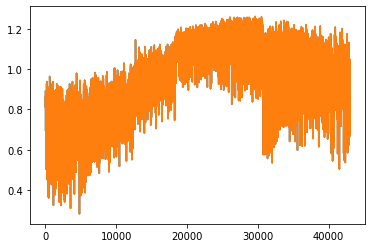

In [4]:
# try adding CH4 to 2M0355 model fit and evaluate sigma  from lnL Bm
from pRT_model import pRT_spectrum
import matplotlib.pyplot as plt

orig_dict=retrieval.params_dict.copy()

retrieval.parameters.params=retrieval.params_dict
print(retrieval.parameters.params['log_CH4'])
model_orig=pRT_spectrum(retrieval).make_spectrum()
lnZ_orig=retrieval.LogLike(model_orig, retrieval.Cov)

# add H2S at low level and see
retrieval.parameters.params['log_CH4']=-6
print(retrieval.parameters.params['log_CH4'])
model_wH2S=pRT_spectrum(retrieval).make_spectrum()
lnZ_wH2S=retrieval.LogLike(model_wH2S, retrieval.Cov)

plt.plot(model_wH2S.flatten())
plt.plot(model_orig.flatten())


print(lnZ_orig,lnZ_wH2S)
lnB, sigma = retrieval.compare_evidence(lnZ_orig,lnZ_wH2S)
retrieval.parameters.params=orig_dict #set back
print(lnB,sigma)

-8.997980828138326
-5
61304.159461462295 61294.40643855627
9.753022906028491 4.798040052527595


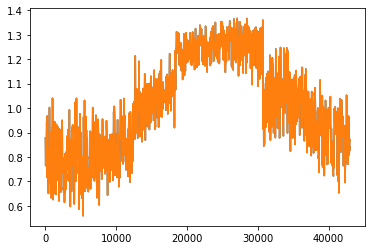

In [6]:
# try adding H2S to 2M1425 model fit and evaluate sigma  from lnL Bm
from pRT_model import pRT_spectrum
import matplotlib.pyplot as plt

orig_dict=retrieval2.params_dict.copy()

retrieval2.parameters.params=retrieval2.params_dict
print(retrieval2.parameters.params['log_H2S'])
model_orig=pRT_spectrum(retrieval2).make_spectrum()
lnZ_orig=retrieval2.LogLike(model_orig, retrieval2.Cov)

# add H2S at low level and see
retrieval2.parameters.params['log_H2S']=-5
print(retrieval2.parameters.params['log_H2S'])
model_wH2S=pRT_spectrum(retrieval2).make_spectrum()
lnZ_wH2S=retrieval2.LogLike(model_wH2S, retrieval2.Cov)

plt.plot(model_wH2S.flatten())
plt.plot(model_orig.flatten())


print(lnZ_orig,lnZ_wH2S)
lnB, sigma = retrieval2.compare_evidence(lnZ_orig,lnZ_wH2S)
retrieval2.parameters.params=orig_dict #set back
print(lnB,sigma)

In [2]:
import numpy as np
10**(4.975)/(10**(4.753))

1.667247212551061

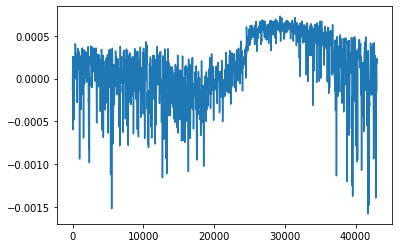

In [16]:
plt.plot(model_wH2S.flatten()-model_orig.flatten())

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib

def CCFs_molecules(retrieval_object1,retrieval_object2,molecules,noiserange=100):

    RVs=np.arange(-500,500,1) # km/s
    comparison_dir=pathlib.Path(f'{retrieval_object1.output_dir}/comparison') # store output in separate folder
    comparison_dir.mkdir(parents=True, exist_ok=True)

    fig,ax=plt.subplots(len(molecules),1,figsize=(5,len(molecules)*1.5),dpi=200)
    for i in range(len(molecules)):
        ax[i].axvspan(-noiserange,noiserange,color='k',alpha=0.05)
        ax[i].set_xlim(np.min(RVs),np.max(RVs))
        ax[i].axvline(x=0,color='k',lw=0.6,alpha=0.3)
        ax[i].axhline(y=0,color='k',lw=0.6,alpha=0.3)

    for i,molecule in enumerate(molecules):

        CCF_norm1=retrieval_object1.CCF_list[i]
        ACF_norm1=retrieval_object1.ACF_list[i]
        SNR1=CCF_norm1[np.where(RVs==0)[0][0]]
        CCF_norm2=retrieval_object2.CCF_list[i]
        ACF_norm2=retrieval_object2.ACF_list[i]
        SNR2=CCF_norm2[np.where(RVs==0)[0][0]]

        ax[i].plot(RVs,CCF_norm1,color=retrieval_object1.color1,label=f'{retrieval_object1.target.name}')
        ax[i].plot(RVs,ACF_norm1,color=retrieval_object1.color1,linestyle='dashed',alpha=0.5)
        ax[i].plot(RVs,CCF_norm2,color=retrieval_object2.color1,label=f'{retrieval_object2.target.name}')
        ax[i].plot(RVs,ACF_norm2,color=retrieval_object2.color1,linestyle='dashed',alpha=0.5)
        ax[i].set_ylabel('S/N')
        molecule_label=str(retrieval_object1.parameters.param_mathtext[f'log_{molecule}'][4:]) # remove log_
        ax[i].text(0.05, 0.9, molecule_label,transform=ax[i].transAxes,fontsize=14,verticalalignment='top')

    lines = [Line2D([0], [0], color=retrieval_object1.color1,linewidth=2,label=f'{retrieval_object1.target.name}'),
                 Line2D([0], [0], color=retrieval_object2.color1,linewidth=2,label=f'{retrieval_object2.target.name}'),
                 Line2D([0], [0], color='k',linewidth=2,alpha=0.5,label='CCF'),
                 Line2D([0], [0], color='k',linestyle='--',linewidth=2,alpha=0.2,label='ACF')]
    ax[0].legend(handles=lines,fontsize=9,loc='upper right')
    ax[len(molecules)-1].set_xlabel(r'$v_{\rm rad}$ (km/s)')
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    filename=f'CCFs_{len(molecules)}.pdf'
    fig.savefig(f'{comparison_dir}/{filename}',bbox_inches="tight",dpi=200)
    plt.close()

CCFs_molecules(retrieval,retrieval2,['13CO','HF'])

# Clouds

In [ ]:
# shouldn't opacity below cloud be high, to block all emission from deeper layers?
# if it's zero, there is effectively no cloud

import numpy as np

params={'log_P_base_gray':-4,'log_opa_base_gray':1,'fsed_gray':4}
wave_micron=np.linspace(1,3,2)
pressure = np.logspace(-6,2,5)
opa_gray_cloud = np.zeros((len(wave_micron),len(pressure))) # gray cloud = independent of wavelength
opa_gray_cloud[:,pressure>10**(params['log_P_base_gray'])] = 10**(params['log_opa_base_gray']) # [bar] constant below cloud base
# Opacity decreases with power-law above the base
above_clouds = (pressure<=10**(params['log_P_base_gray']))
opa_gray_cloud[:,above_clouds]=(10**(params['log_opa_base_gray']))*(pressure[above_clouds]/10**(params['log_P_base_gray']))**params['fsed_gray']

print(opa_gray_cloud)
print(pressure)

[[1.e-07 1.e+01 1.e+01 1.e+01 1.e+01]
 [1.e-07 1.e+01 1.e+01 1.e+01 1.e+01]]
[1.e-06 1.e-04 1.e-02 1.e+00 1.e+02]


# Table for paper

In [1]:
import pathlib
import pickle
import numpy as np

path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.5/params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)

path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M1425/freechem_PTgrad_N400_ev0.5/params_dict.pickle')
with open(path,'rb') as file:
    final_params2=pickle.load(file)

In [3]:
dec=2
table=["C/O &","$[$C/H$]$ &","log $^{12}$CO/$^{13}$CO &","log $^{12}$CO/C$^{17}$O &",
       "log $^{12}$CO/C$^{18}$O &","log H$_2$O/H$_2^{18}$O &"]
ratios=["C/O","C/H",'log_12CO/13CO','log_12CO/C17O','log_12CO/C18O','log_H2O/H2(18)O']

for i,r in enumerate(ratios):
      print(table[i],np.round(final_params[r][0],decimals=dec),
              "$^{+",np.round(final_params[f'{r}_err'][1][0],decimals=dec),"}_{",
              np.round(final_params[f'{r}_err'][0][0],decimals=dec),"}$ &",
              np.round(final_params2[r][0],decimals=dec),
              "$^{+",np.round(final_params2[f'{r}_err'][1][0],decimals=dec),"}_{",
              np.round(final_params2[f'{r}_err'][0][0],decimals=dec),"}$ \\\\")

C/O & 0.65 $^{+ 0.01 }_{ -0.01 }$ & 0.66 $^{+ 0.0 }_{ -0.0 }$ \\
$[$C/H$]$ & 0.58 $^{+ 0.03 }_{ -0.03 }$ & 0.4 $^{+ 0.01 }_{ -0.01 }$ \\
log $^{12}$CO/$^{13}$CO & 1.98 $^{+ 0.03 }_{ -0.03 }$ & 2.04 $^{+ 0.04 }_{ -0.04 }$ \\
log $^{12}$CO/C$^{17}$O & 6.29 $^{+ 1.5 }_{ -1.42 }$ & 5.52 $^{+ 1.39 }_{ -1.17 }$ \\
log $^{12}$CO/C$^{18}$O & 5.22 $^{+ 1.9 }_{ -1.6 }$ & 6.31 $^{+ 1.31 }_{ -1.4 }$ \\
log H$_2$O/H$_2^{18}$O & 4.31 $^{+ 3.11 }_{ -1.49 }$ & 2.71 $^{+ 3.05 }_{ -0.2 }$ \\


In [4]:
import pathlib
import pickle
import numpy as np

path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.5/evidence_dict.pickle')
with open(path,'rb') as file:
    evidence=pickle.load(file)

path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M1425/freechem_PTgrad_N400_ev0.5/evidence_dict.pickle')
with open(path,'rb') as file:
    evidence2=pickle.load(file)

dec=1
table=["$^{13}$CO",'HF','H$_2$S','H$_2^{18}$O','CH$_4$']
molec=['13CO','HF','H2S','H2(18)O', 'CH4']

for i,m in enumerate(molec):
      print(table[i],'&',
            np.round(final_params[f'SNR_{m}'],decimals=dec),"&",
            np.round(evidence[f'sigma_{m}'],decimals=dec),"&",
            np.round(final_params2[f'SNR_{m}'],decimals=dec),"&",
            np.round(evidence2[f'sigma_{m}'],decimals=dec),"\\\\")

$^{13}$CO & 12.4 & 13.4 & 3.5 & 8.0 \\
HF & 16.9 & 11.6 & 5.5 & 15.8 \\
H$_2$S & 6.2 & 4.6 & -0.5 & 9.3 \\
H$_2^{18}$O & 2.6 & 1.1 & 1.5 & 3.0 \\
CH$_4$ & -0.7 & 2.2 & 4.9 & 5.5 \\


In [4]:
dec=3

table=["$v_{\\text{rad}}$ [km/s] & Radial velocity & $\mathcal{U}$(2,20) &",
       "$v\\text{sin}i$ [km/s] & Projected rotational velocity & $\mathcal{U}$(0,40) &",
       "log $g$ [cm/s$^2$] & Surface gravity & $\mathcal{U}$(3,5) &",
       "$\epsilon_\mathrm{limb}$ & Limb-darkening coefficient & $\mathcal{U}$(0.2,1) &",
       "",
       "log H$_2$O & log$_{10}$ VMR of H$_2$O & $\mathcal{U}$(-12,-1) & ",
       "log $^{12}$CO & log$_{10}$ VMR of $^{12}$CO & $\mathcal{U}$(-12,-1) &",
       "log $^{13}$CO & log$_{10}$ VMR of $^{13}$CO & $\mathcal{U}$(-12,-1) & ",
       "log C$^{18}$O & log$_{10}$ VMR of C$^{18}$O & $\mathcal{U}$(-12,-1) &",
       "log C$^{17}$O & log$_{10}$ VMR of C$^{17}$O & $\mathcal{U}$(-12,-1) &",
       "log CH$_4$ & log$_{10}$ VMR of CH$_4$ & $\mathcal{U}$(-12,-1) &",
       "log NH$_3$ & log$_{10}$ VMR of NH$_3$ & $\mathcal{U}$(-12,-1) & ",
       "log HCN & log$_{10}$ VMR of HCN & $\mathcal{U}$(-12,-1) &",
       "log HF & log$_{10}$ VMR of HF & $\mathcal{U}$(-12,-1) & ",
       "log H$_2$S & log$_{10}$ VMR of H$_2$S & $\mathcal{U}$(-12,-1) & ",
       "log H$_2^{18}$O & log$_{10}$ VMR of H$_2^{18}$O & $\mathcal{U}$(-12,-1) &",
      "",
      "$T_0$ [K] & Temperature at $P_0=10^2\,$bar& $\mathcal{U}$(1000,4000) &",
      " $\\nabla T_0$ & Temperature gradient at $P_0=10^2\,$bar& $\mathcal{U}$(0,0.4) &",
      "$\\nabla T_1$ & Temperature gradient at $P_1=10^0\,$bar& $\mathcal{U}$(0,0.4) &",
      "$\\nabla T_2$ & Temperature gradient at $P_2=10^0\,$bar& $\mathcal{U}$(0,0.4) &",
      "$\\nabla T_3$ & Temperature gradient at $P_3=10^0\,$bar& $\mathcal{U}$(0,0.4) &",
      "$\\nabla T_4$ & Temperature gradient at $P_4=10^0\,$bar& $\mathcal{U}$(0,0.4) &",
      "",
      "log $\kappa_{\mathrm{cl},0}$ [cm$^2$/g] & Opacity at cloud base & $\mathcal{U}$(-10,3) & ",
      "log $P_{\mathrm{cl},0}$ [bar] & Cloud base pressure & $\mathcal{U}$(-6,3) &",
      "$f_\mathrm{sed}$ & Cloud decay power & $\mathcal{U}$(0,20) &",
      "",
      "log $a$ & GP amplitude & $\mathcal{U}$(-1,1) &",
      "log $l$ [nm] & GP length-scale & $\mathcal{U}$(-3,0) &"]
table_vals=['rv','vsini','log_g','epsilon_limb',"",'log_H2O',"log_12CO","log_13CO",
            "log_C18O","log_C17O","log_CH4","log_NH3","log_HCN","log_HF","log_H2S",
            "log_H2(18)O","",'T0','dlnT_dlnP_0','dlnT_dlnP_1','dlnT_dlnP_2',
            'dlnT_dlnP_3','dlnT_dlnP_4',"","log_opa_base_gray","log_P_base_gray",
            "fsed_gray","","log_a","log_l"]

if True:
      for i,tpar in enumerate(table_vals):
            if tpar=="":
                  print("\hline")
            else:
                  print(table[i],np.round(final_params[tpar],decimals=dec),
                        "$^{+",np.round(final_params[f'{tpar}_err'][1],decimals=dec),"}_{",
                        np.round(final_params[f'{tpar}_err'][0],decimals=dec),"}$ &",
                        np.round(final_params2[tpar],decimals=dec),
                        "$^{+",np.round(final_params2[f'{tpar}_err'][1],decimals=dec),"}_{",
                        np.round(final_params2[f'{tpar}_err'][0],decimals=dec),"}$ \\\\")

$v_{\text{rad}}$ [km/s] & Radial velocity & $\mathcal{U}$(2,20) & 13.251 $^{+ 0.009 }_{ -0.009 }$ & 5.538 $^{+ 0.045 }_{ -0.046 }$ \\
$v\text{sin}i$ [km/s] & Projected rotational velocity & $\mathcal{U}$(0,40) & 3.043 $^{+ 0.081 }_{ -0.081 }$ & 31.575 $^{+ 0.186 }_{ -0.232 }$ \\
log $g$ [cm/s$^2$] & Surface gravity & $\mathcal{U}$(3,5) & 4.753 $^{+ 0.034 }_{ -0.034 }$ & 4.975 $^{+ 0.01 }_{ -0.011 }$ \\
$\epsilon_\mathrm{limb}$ & Limb-darkening coefficient & $\mathcal{U}$(0.2,1) & 0.721 $^{+ 0.141 }_{ -0.155 }$ & 0.741 $^{+ 0.036 }_{ -0.048 }$ \\
\hline
log H$_2$O & log$_{10}$ VMR of H$_2$O & $\mathcal{U}$(-12,-1) &  -2.999 $^{+ 0.026 }_{ -0.031 }$ & -3.197 $^{+ 0.008 }_{ -0.01 }$ \\
log $^{12}$CO & log$_{10}$ VMR of $^{12}$CO & $\mathcal{U}$(-12,-1) & -2.735 $^{+ 0.026 }_{ -0.035 }$ & -2.92 $^{+ 0.01 }_{ -0.013 }$ \\
log $^{13}$CO & log$_{10}$ VMR of $^{13}$CO & $\mathcal{U}$(-12,-1) &  -4.717 $^{+ 0.04 }_{ -0.044 }$ & -4.958 $^{+ 0.037 }_{ -0.039 }$ \\
log C$^{18}$O & log$_{10}$ VMR o

# Make plots for presentation

In [ ]:
import getpass
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when runnig from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    os.environ['OMP_NUM_THREADS'] = '1' # important for MPI
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    from atm_retrieval.target import Target
    from atm_retrieval.likelihood import Retrieval
    from atm_retrieval.parameters import Parameters
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from likelihood import Retrieval
    from parameters import Parameters
    from pRT_model import pRT_spectrum


M0355 = Target('2M0355')
data_wave,data_flux,data_err=M0355.load_spectrum()

constant_params = {'vsini': 2, # rotational velocity
                'rv': 11.92,
                'log_Kzz': 7.5, # eddy diffusion parameter (atmospheric mixing)
                'fsed': 2, # sedimentation parameter for particles
                'P_base_gray': 1, # pressure of gray cloud deck
                'fsed_gray': 2,
                'opa_base_gray': 0.8, # opacity of gray cloud deck
                'sigma_lnorm': 1.05, # width of the log-normal particle distribution of MgSiO3
                'log_MgSiO3' : 0, # scaling wrt chem equilibrium, 0 = equilibrium abundance 
                'log_H2O': -2.9,#-2.9,
                'log_12CO': -2.67,#-2.66,
                'log_13CO':-4.9,
                'log_C18O':-12, #-8.3,
                'log_C17O':-12,  #-8.7,
                'log_CH4':-12, #-8.6,
                'log_NH3':-12, #-8.9,
                'log_HCN':-12, #-8,
                'T1' : 2500, # bottom of the atmosphere (hotter)
                'T2' : 1500,
                'T3' : 1270,
                'T4' : 313, # top of atmosphere (cooler)
                'log_g':4.95,
                } 

free_params = {}
parameters = Parameters(free_params,constant_params)
params=parameters.params


output='2M0355_test4'
retrieval=Retrieval(target=M0355,parameters=parameters,output_name=output)
atmosphere_objects=retrieval.atmosphere_objects

species=retrieval.get_species(param_dict=parameters.params)
model_flux=pRT_spectrum(parameters=params,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()


In [ ]:
params_H2O=params.copy()
params_H2O['log_12CO']=-12
params_H2O['log_13CO']=-12
H2O_flux=pRT_spectrum(parameters=params_H2O,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

params_CO=params.copy()
params_CO['log_H2O']=-12
params_CO['log_13CO']=-12
CO_flux=pRT_spectrum(parameters=params_CO,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(7,3),dpi=200,sharex=True)
order=5
det=0
for i in range(2):
    ax[i].plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
    ax[i].set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
    ax[i].yaxis.set_visible(False) # remove ylabels because anyway unitless

ax[0].plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
ax[1].plot(data_wave[order,det],H2O_flux[order,det],lw=1,alpha=0.8,c='tab:blue',label='H$_2$O')
ax[1].plot(data_wave[order,det],CO_flux[order,det],lw=1,alpha=0.8,c='tab:orange',label='CO')

ax[0].legend(fontsize=8)
ax[1].legend(fontsize=8)
ax[1].set_xlabel('Wavelength [nm]')
fig.tight_layout(h_pad=-0.1)
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/spectrum.jpg')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/model.jpg')

In [ ]:
params_bad=params.copy()
params_bad['log_H2O']=-3.5
params_bad['log_CO']=-2
params_bad['vsini']=7
params_bad['T1']=1700
bad_flux=pRT_spectrum(parameters=params_bad,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],bad_flux[order,det],lw=1,alpha=1,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/bad_model1.jpg')